<a href="https://colab.research.google.com/github/ynes99/fire-detection/blob/main/dataset_prepping%2Btiny_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports
ref : https://colab.research.google.com/github/luxonis/depthai-ml-training/blob/master/colab-notebooks/YoloV3_V4_tiny_training.ipynb#scrollTo=fwRcypwSxdnw

In [ ]:
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf #choosing tensorflow version
tf.__version__
from shutil import copyfile
import os
import shutil
from google.colab import drive
import re
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import inspect
import random
import sys

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Utilities:

In [ ]:

def extract_log(log_file,new_log_file,key_word):
    with open(log_file, 'r') as f:
      with open(new_log_file, 'w') as train_log:
  #f = open(log_file)
    #train_log = open(new_log_file, 'w')
        for line in f:
          if 'Syncing' in line:
            continue
          if 'nan' in line:
            continue
          if 'Region 82 Avg' in line:
            continue
          if 'Region 94 Avg' in line:
            continue
          if 'Region 106 Avg' in line:
            continue
          if 'total_bbox' in line:
            continue  
          if 'Loaded' in line:
            continue              
          if key_word in line:
            train_log.write(line)
    f.close()
    train_log.close()

def extract_log2(log_file,new_log_file,key_word):
    with open(log_file, 'r') as f:
      with open(new_log_file, 'w') as train_log:
  #f = open(log_file)
    #train_log = open(new_log_file, 'w')
        for line in f:
          if 'Syncing' in line:
            continue
          if 'nan' in line:
            continue
          if 'Region 94 Avg' in line:
            continue
          if 'Region 106 Avg' in line:
            continue
          if 'total_bbox' in line:
            continue  
          if 'Loaded' in line:
            continue     
          if 'IoU: 0.000000' in line:
            continue                          
          if key_word in line:
            del_num=line.replace("v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (", "")
            train_log.write(del_num.replace(")", ""))
          
    f.close()
    train_log.close() 

In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

## 1. Mount the drive

In [ ]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd MyDrive/Dataset_fire_detection

/gdrive/MyDrive/Dataset_fire_detection


In [ ]:
%ls

 annotation/         data/             obj_test.data     yolov3-tiny.conv.15
 backup/             imgs/             README.txt       'yolov3 tiny logs'/
 classes.txt         metadata1.5.csv   yolov3.cfg
 darknet/            metadata1.6.csv  'yolov3 logs'/
 darknet53.conv.74   obj.data          yolov3-tiny.cfg


##2. Setting up Darknet

In [ ]:
%%capture
!git clone https://github.com/AlexeyAB/darknet.git

In [ ]:
%cd darknet

/gdrive/MyDrive/Dataset_fire_detection/darknet


In [ ]:

!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make


chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!chmod +x ./darknet

In [ ]:
%ls

 3rdparty/                counters_per_class.txt   net_cam_v4.sh
 anchors.txt              darknet*                 obj/
 avg_loss.png             DarknetConfig.cmake.in   predictions.jpg
 backup/                  darknet_images.py        README.md
 bad.list                 darknet.py               result.json
 build/                   darknet_video.py         results/
 build.ps1                data/                    result.txt
 cfg/                     image_yolov3.sh          scripts/
 chart.png                image_yolov4.sh          src/
 chart_yolov3-tiny.png    include/                 train.log
 cmake/                   json_mjpeg_streams.sh    vcpkg.json
 CMakeLists.txt           LICENSE                  video_yolov3.sh
'Copie de train V2.log'   Makefile                 video_yolov4.sh
 core                     net_cam_v3.sh


## 3. Dataset preparation (train-dev-test)
- 1st dataset (from mr aamrou) :  
Shuffle data then split into :  
 70% train set  
 15% dev set  
 15% test set  
(all fire images big and the background seemingly outdoorsy forest background or car on fire)  
Total of images: 595 element
- 2nd dataset (from me):  
three types of elements: img contains various vehicules on fire, pic various elements on fire (daily life; kitchen fire, car, houses) , and small indicates small flames like candles etc.  
I am spliting the data for each category of images with this percentage (the dataset is small) :  
 60% train  
 20% dev  
 20% test
Total of images: 502 element

In [ ]:
df = pd.read_csv('metadata.csv')
#df.style

In [ ]:
first_dataset = df.loc[df['Dataset used'] == '1st dataset']
shuffled = first_dataset.sample(frac=1)
shuffled.style

In [ ]:
train_set = shuffled[:417] #70%
dev_set = shuffled[417:418+88] #15%
test_set = shuffled[418+88::] #15%

In [ ]:
len(train_set)

417

In [ ]:
train_set.fillna('', inplace=True)
train_set['Description']='Train'

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dev_set.fillna('', inplace=True)
dev_set['Description']='Dev'

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_set.fillna('', inplace=True)
test_set['Description']='Test'

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_1st_df = pd.concat([train_set,dev_set,test_set])

In [ ]:
sorted_1dataset = final_1st_df.sort_index()

In [ ]:
second_dataset = df.loc[df['Dataset used'] == '2nd dataset']
shuffled2 = second_dataset.sample(frac=1)
shuffled2

Basename Image     Annotation Dataset used  Description
887   pic (33).jpg   pic (33).txt  2nd dataset          NaN
911   pic (55).jpg   pic (55).txt  2nd dataset          NaN
815  pic (165).jpg  pic (165).txt  2nd dataset          NaN
862  pic (207).jpg  pic (207).txt  2nd dataset          NaN
944   pic (85).jpg   pic (85).txt  2nd dataset          NaN
..             ...            ...          ...          ...
952   pic (92).jpg   pic (92).txt  2nd dataset          NaN
607   img (11).jpg   img (11).txt  2nd dataset          NaN
654    img (2).jpg    img (2).txt  2nd dataset          NaN
948   pic (89).jpg   pic (89).txt  2nd dataset          NaN
867  pic (211).jpg  pic (211).txt  2nd dataset          NaN

[502 rows x 4 columns]

In [ ]:
pic_set = shuffled2.loc[shuffled2['Basename Image'].str.contains('pic')]
pic_set

Basename Image     Annotation Dataset used  Description
887   pic (33).jpg   pic (33).txt  2nd dataset          NaN
911   pic (55).jpg   pic (55).txt  2nd dataset          NaN
815  pic (165).jpg  pic (165).txt  2nd dataset          NaN
862  pic (207).jpg  pic (207).txt  2nd dataset          NaN
944   pic (85).jpg   pic (85).txt  2nd dataset          NaN
..             ...            ...          ...          ...
794  pic (146).jpg  pic (146).txt  2nd dataset          NaN
767  pic (121).jpg  pic (121).txt  2nd dataset          NaN
952   pic (92).jpg   pic (92).txt  2nd dataset          NaN
948   pic (89).jpg   pic (89).txt  2nd dataset          NaN
867  pic (211).jpg  pic (211).txt  2nd dataset          NaN

[218 rows x 4 columns]

In [ ]:
pic_train_set = pic_set[:130] #60%
pic_dev_set = pic_set[130:130+44] #20%
pic_test_set = pic_set[130+44::] #20%
pic_train_set.fillna('', inplace=True)
pic_train_set['Description']='Train'
pic_dev_set.fillna('', inplace=True)
pic_dev_set['Description']='Dev'
pic_test_set.fillna('', inplace=True)
pic_test_set['Description']='Test'
frames = [pic_train_set,pic_dev_set,pic_test_set]
final_pic_df = pd.concat(frames)
sorted_pic = final_pic_df.sort_index()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [ ]:
img_set = shuffled2.loc[shuffled2['Basename Image'].str.contains('img')]
img_set

Basename Image     Annotation Dataset used  Description
616  img (118).jpg  img (118).txt  2nd dataset          NaN
626  img (127).jpg  img (127).txt  2nd dataset          NaN
672   img (36).jpg   img (36).txt  2nd dataset          NaN
601  img (104).jpg  img (104).txt  2nd dataset          NaN
642  img (141).jpg  img (141).txt  2nd dataset          NaN
..             ...            ...          ...          ...
621  img (122).jpg  img (122).txt  2nd dataset          NaN
641  img (140).jpg  img (140).txt  2nd dataset          NaN
676    img (4).jpg    img (4).txt  2nd dataset          NaN
607   img (11).jpg   img (11).txt  2nd dataset          NaN
654    img (2).jpg    img (2).txt  2nd dataset          NaN

[147 rows x 4 columns]

In [ ]:
img_train_set = img_set[:91] #60%
img_dev_set = img_set[91:91+28] #20%
img_test_set = img_set[91+28::] #20%
img_train_set.fillna('', inplace=True)
img_train_set['Description']='Train'
img_dev_set.fillna('', inplace=True)
img_dev_set['Description']='Dev'
img_test_set.fillna('', inplace=True)
img_test_set['Description']='Test'
frames = [img_train_set,img_dev_set,img_test_set]
final_img_df = pd.concat(frames)
sorted_img = final_img_df.sort_index()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [ ]:
small_set = shuffled2.loc[shuffled2['Basename Image'].str.contains('small')]
small_set

Basename Image       Annotation Dataset used  Description
1007   small (18).jpg   small (18).txt  2nd dataset          NaN
1064    small (7).jpg    small (7).txt  2nd dataset          NaN
1053    small (6).jpg    small (6).txt  2nd dataset          NaN
990   small (126).jpg  small (126).txt  2nd dataset          NaN
1071   small (76).jpg   small (76).txt  2nd dataset          NaN
...               ...              ...          ...          ...
1081   small (85).jpg   small (85).txt  2nd dataset          NaN
967   small (105).jpg  small (105).txt  2nd dataset          NaN
1034   small (42).jpg   small (42).txt  2nd dataset          NaN
995   small (130).jpg  small (130).txt  2nd dataset          NaN
1063   small (69).jpg   small (69).txt  2nd dataset          NaN

[137 rows x 4 columns]

In [ ]:
small_train_set = small_set[:85] #60%
small_dev_set = small_set[85:85+26] #20%
small_test_set = small_set[85+26::] #20%
small_train_set.fillna('', inplace=True)
small_train_set['Description']='Train'
small_dev_set.fillna('', inplace=True)
small_dev_set['Description']='Dev'
small_test_set.fillna('', inplace=True)
small_test_set['Description']='Test'
frames = [small_train_set,small_dev_set,small_test_set]
final_small_df = pd.concat(frames)
sorted_small = final_small_df.sort_index()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [ ]:
final_df = pd.concat([sorted_1dataset,sorted_img,sorted_pic,sorted_small])

In [ ]:
final_df

Basename Image      Annotation Dataset used Description
0        001_rgb.png     001_rgb.txt  1st dataset       Train
1        002_rgb.png     002_rgb.txt  1st dataset       Train
2        003_rgb.png     003_rgb.txt  1st dataset        Test
3        004_rgb.png     004_rgb.txt  1st dataset        Test
4        005_rgb.png     005_rgb.txt  1st dataset       Train
...              ...             ...          ...         ...
1092  small (95).jpg  small (95).txt  2nd dataset       Train
1093  small (96).jpg  small (96).txt  2nd dataset         Dev
1094  small (97).jpg  small (97).txt  2nd dataset       Train
1095  small (98).jpg  small (98).txt  2nd dataset       Train
1096  small (99).jpg  small (99).txt  2nd dataset       Train

[1097 rows x 4 columns]

In [ ]:
final_df.to_csv('metadata1.1.csv',index=False)

In [ ]:
final_df = final_df.sort_values(by='Basename Image')

In [ ]:
df_bis = pd.read_csv('metadata1.5.csv')
df_bis

Basename Image      Annotation Dataset used Description
0        001_rgb.png     001_rgb.txt  1st dataset       Train
1        002_rgb.png     002_rgb.txt  1st dataset       Train
2        003_rgb.png     003_rgb.txt  1st dataset        Test
3        004_rgb.png     004_rgb.txt  1st dataset        Test
4        005_rgb.png     005_rgb.txt  1st dataset       Train
...              ...             ...          ...         ...
1092  small_(95).jpg  small_(95).txt  2nd dataset       Train
1093  small_(96).jpg  small_(96).txt  2nd dataset         Dev
1094  small_(97).jpg  small_(97).txt  2nd dataset       Train
1095  small_(98).jpg  small_(98).txt  2nd dataset       Train
1096  small_(99).jpg  small_(99).txt  2nd dataset       Train

[1097 rows x 4 columns]

In [ ]:
Basename_im = list(df_bis['Basename Image']) #train dev test
Desc = list(df_bis['Description'])
root_dir = r'/gdrive/MyDrive/Dataset_fire_detection/data'
dev_path = os.path.join(root_dir,'Dev')
train_path = os.path.join(root_dir,'Train')
test_path = os.path.join(root_dir,'Test')
imgs_path = r'/gdrive/MyDrive/Dataset_fire_detection/imgs'
annot_path = r'/gdrive/MyDrive/Dataset_fire_detection/annotation'

In [ ]:
print(Basename_im)
print(Desc)
print(dev_path)

['001_rgb.png', '002_rgb.png', '003_rgb.png', '004_rgb.png', '005_rgb.png', '006_rgb.png', '007_rgb.png', '008_rgb.png', '009_rgb.png', '010_rgb.png', '011_rgb.png', '012_rgb.png', '013_rgb.png', '014_rgb.png', '015_rgb.png', '016_rgb.png', '017_rgb.png', '018_rgb.png', '019_rgb.png', '020_rgb.png', '021_rgb.png', '022_rgb.png', '023_rgb.png', '024_rgb.png', '025_rgb.png', '026_rgb.png', '027_rgb.png', '028_rgb.png', '029_rgb.png', '030_rgb.png', '031_rgb.png', '032_rgb.png', '033_rgb.png', '034_rgb.png', '035_rgb.png', '036_rgb.png', '037_rgb.png', '038_rgb.png', '039_rgb.png', '040_rgb.png', '041_rgb.png', '042_rgb.png', '043_rgb.png', '044_rgb.png', '045_rgb.png', '046_rgb.png', '047_rgb.png', '048_rgb.png', '049_rgb.png', '050_rgb.png', '051_rgb.png', '052_rgb.png', '053_rgb.png', '054_rgb.png', '055_rgb.png', '056_rgb.png', '057_rgb.png', '058_rgb.png', '059_rgb.png', '060_rgb.png', '061_rgb.png', '062_rgb.png', '063_rgb.png', '064_rgb.png', '065_rgb.png', '066_rgb.png', '067_rgb.

In [ ]:
#copyfile(src, dst)
for file_name,description in zip(Basename_im,Desc) :
  if description == 'Train':
    dst = train_path
  elif description == 'Dev':
    dst = dev_path
  elif description == 'Test':
    dst = test_path
  else:
    raise Exception 
  src = os.path.join(imgs_path,file_name)
  dst = os.path.join(dst,file_name)
  print(src)
  print(dst)
  copyfile(src,dst)

In [ ]:
Basename_annot = list(df_bis['Annotation'])
print(Basename_annot)

['001_rgb.txt', '002_rgb.txt', '003_rgb.txt', '004_rgb.txt', '005_rgb.txt', '006_rgb.txt', '007_rgb.txt', '008_rgb.txt', '009_rgb.txt', '010_rgb.txt', '011_rgb.txt', '012_rgb.txt', '013_rgb.txt', '014_rgb.txt', '015_rgb.txt', '016_rgb.txt', '017_rgb.txt', '018_rgb.txt', '019_rgb.txt', '020_rgb.txt', '021_rgb.txt', '022_rgb.txt', '023_rgb.txt', '024_rgb.txt', '025_rgb.txt', '026_rgb.txt', '027_rgb.txt', '028_rgb.txt', '029_rgb.txt', '030_rgb.txt', '031_rgb.txt', '032_rgb.txt', '033_rgb.txt', '034_rgb.txt', '035_rgb.txt', '036_rgb.txt', '037_rgb.txt', '038_rgb.txt', '039_rgb.txt', '040_rgb.txt', '041_rgb.txt', '042_rgb.txt', '043_rgb.txt', '044_rgb.txt', '045_rgb.txt', '046_rgb.txt', '047_rgb.txt', '048_rgb.txt', '049_rgb.txt', '050_rgb.txt', '051_rgb.txt', '052_rgb.txt', '053_rgb.txt', '054_rgb.txt', '055_rgb.txt', '056_rgb.txt', '057_rgb.txt', '058_rgb.txt', '059_rgb.txt', '060_rgb.txt', '061_rgb.txt', '062_rgb.txt', '063_rgb.txt', '064_rgb.txt', '065_rgb.txt', '066_rgb.txt', '067_rgb.

In [ ]:
#copyfile(src, dst)
for file_name,description in zip(Basename_annot,Desc) :
  if description == 'Train':
    dst = train_path
  elif description == 'Dev':
    dst = dev_path
  elif description == 'Test':
    dst = test_path
  else:
    raise Exception 
  src = os.path.join(annot_path,file_name)
  dst = os.path.join(dst,file_name)
  print(src)
  print(dst)
  copyfile(src,dst)

### Dataset

In [ ]:
Desc.count('Train')

723

In [ ]:
Desc.count('Dev')

187

In [ ]:
Desc.count('Test')

187

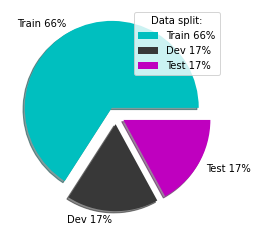

In [ ]:
y = np.array([723, 187, 187])
mylabels = ["Train 66%", "Dev 17%", "Test 17%"]
myexplode = [0.1, 0.1, 0.1]
mycolors = ["c", "#383838", "m"]
plt.pie(y, labels = mylabels, explode = myexplode, shadow = True,colors=mycolors)
plt.legend(title = "Data split:")
plt.show() 

## 4. Train preparation

### 4.1 Download weights for YoloV3-tiny

In [ ]:
!wget https://github.com/GotG/yolotinyv3_medmask_demo/raw/master/yolov3-tiny.conv.15

--2022-06-21 15:07:48--  https://github.com/GotG/yolotinyv3_medmask_demo/raw/master/yolov3-tiny.conv.15
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GotG/yolotinyv3_medmask_demo/master/yolov3-tiny.conv.15 [following]
--2022-06-21 15:07:48--  https://raw.githubusercontent.com/GotG/yolotinyv3_medmask_demo/master/yolov3-tiny.conv.15
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30973396 (30M) [application/octet-stream]
Saving to: ‘yolov3-tiny.conv.15’

yolov3-tiny.conv.15 100%[===================>]  29.54M  54.3MB/s    in 0.5s    

2022-06-21 15:07:49 (54.3 MB/s) - ‘yolov3-tiny.conv.15’ saved 

### 4.2 obj.names
We create the `obj.names`. Each line must be its own text label.

In [ ]:
labels = ['fire']

In [ ]:
labels_path = r"/gdrive/MyDrive/Dataset_fire_detection/data/obj.names"

with open(labels_path, 'w') as f:
    f.write('\n'.join(labels))

#check that the labels file is correct
!cat "/gdrive/MyDrive/Dataset_fire_detection/data/obj.names"

fire

### 4.3 obj.data

We set up `obj.data`, which needs to include the number of classes, paths to train, validation, and test *txts*, path to the *obj.names*, and the name of the folder where weights will be saved.




In [ ]:
%ls

annotation/  darknet/  metadata1.1.csv  metadata.csv   README.txt
backup/      data/     metadata1.3.csv  obj.data       yolov3-tiny.cfg
classes.txt  imgs/     metadata1.5.csv  obj_test.data  yolov3-tiny.conv.15


In [ ]:
tr_df = df_bis.loc[df_bis['Description']=='Train']
print( tr_df)

      Basename Image      Annotation Dataset used Description
0        001_rgb.png     001_rgb.txt  1st dataset       Train
1        002_rgb.png     002_rgb.txt  1st dataset       Train
4        005_rgb.png     005_rgb.txt  1st dataset       Train
7        008_rgb.png     008_rgb.txt  1st dataset       Train
8        009_rgb.png     009_rgb.txt  1st dataset       Train
...              ...             ...          ...         ...
1091  small_(94).jpg  small_(94).txt  2nd dataset       Train
1092  small_(95).jpg  small_(95).txt  2nd dataset       Train
1094  small_(97).jpg  small_(97).txt  2nd dataset       Train
1095  small_(98).jpg  small_(98).txt  2nd dataset       Train
1096  small_(99).jpg  small_(99).txt  2nd dataset       Train

[723 rows x 4 columns]


In [ ]:
img_tr_list = list(tr_df['Basename Image'])
root_dir = r'/gdrive/MyDrive/Dataset_fire_detection/data/Train'
tr_img_path = [os.path.join(root_dir,file_name) for file_name in img_tr_list]
print(tr_img_path)
with open('/gdrive/MyDrive/Dataset_fire_detection/data/train.txt', 'w') as f:
    for item in tr_img_path:
        f.write("%s\n" % item)

['/gdrive/MyDrive/Dataset_fire_detection/data/Train/001_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/002_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/005_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/008_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/009_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/010_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/013_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/014_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/017_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/018_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/019_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/020_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/022_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/024_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Train/025_rgb.png', '/gdrive/MyDrive/Dataset

In [ ]:
d_df = df_bis.loc[df_bis['Description']=='Dev']
img_d_list = list(d_df['Basename Image'])
root_dir = r'/gdrive/MyDrive/Dataset_fire_detection/data/Dev'
d_img_path = [os.path.join(root_dir,file_name) for file_name in img_d_list]
print(d_img_path)
with open('/gdrive/MyDrive/Dataset_fire_detection/data/dev.txt', 'w') as f:
    for item in d_img_path:
        f.write("%s\n" % item)

['/gdrive/MyDrive/Dataset_fire_detection/data/Dev/023_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/029_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/041_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/043_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/045_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/055_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/059_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/060_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/061_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/068_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/071_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/077_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/085_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/087_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/088_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Dev/094_r

In [ ]:
te_df = df_bis.loc[df_bis['Description']=='Test']
img_te_list = list(te_df['Basename Image'])
root_dir = r'/gdrive/MyDrive/Dataset_fire_detection/data/Test'
te_img_path = [os.path.join(root_dir,file_name) for file_name in img_te_list]
print(te_img_path)
with open('/gdrive/MyDrive/Dataset_fire_detection/data/test.txt', 'w') as f:
    for item in te_img_path:
        f.write("%s\n" % item)

['/gdrive/MyDrive/Dataset_fire_detection/data/Test/003_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/004_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/006_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/007_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/011_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/012_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/015_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/016_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/021_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/030_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/040_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/042_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/057_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/067_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/069_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection

In [ ]:
#the number of classes is equal to the number of labels
num_classes = len(labels)


In [ ]:
objdata = '/gdrive/MyDrive/Dataset_fire_detection/obj.data'


with open(objdata, 'w') as f:
  f.write(f"classes = {num_classes}\n")
  f.write(f"train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt\n") 
  f.write(f"valid = /gdrive/MyDrive/Dataset_fire_detection/data/dev.txt\n") 
  f.write(f"names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names\n")
  f.write(f"backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup")


In [ ]:
!cat '/gdrive/MyDrive/Dataset_fire_detection/obj.data'

classes = 1
train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt
valid = /gdrive/MyDrive/Dataset_fire_detection/data/dev.txt
names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names
backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup

In [ ]:
objdata = '/gdrive/MyDrive/Dataset_fire_detection/obj_test.data'

#the number of classes is equal to the number of labels
num_classes = len(labels)

with open(objdata, 'w') as f:
  f.write(f"classes = {num_classes}\n")
  f.write(f"train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt\n") 
  f.write(f"valid = /gdrive/MyDrive/Dataset_fire_detection/data/test.txt\n") 
  f.write(f"names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names\n")
  f.write(f"backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup")

In [ ]:
!cat '/gdrive/MyDrive/Dataset_fire_detection/obj_test.data'

classes = 1
train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt
valid = /gdrive/MyDrive/Dataset_fire_detection/data/test.txt
names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names
backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup

### 4.4 Config file

In [ ]:
!cp '/gdrive/MyDrive/Dataset_fire_detection/darknet/cfg/yolov3-tiny.cfg' '/gdrive/MyDrive/Dataset_fire_detection/yolov3-tiny.cfg'

In [ ]:
cfg_file = f'/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3-tiny.cfg'
cfg_file

'/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3-tiny.cfg'

In [ ]:
weights_file = '/gdrive/MyDrive/Dataset_fire_detection/weights/yolov3-tiny.conv.15'
weights_file

'/gdrive/MyDrive/Dataset_fire_detection/weights/yolov3-tiny.conv.15'

#### 4.4.1 Setting parameters

You can set a custom height and width, as long as they are both divisible by *32*.

**Other parameters**

We set other parameters according to [this tutorial](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects).

In [ ]:
labels = ['fire']
num_classes = len(labels)

In [ ]:
# must be divisible by 32
yolo_height = 320
yolo_width = 512

# set the number of max_batches - min 2000 per class:
max_batch = num_classes * 2500
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3

batch = 64
subdivisions = 16 #4 images per iteration how many iterations ? plot the epochs
burn_in = 100
#learning_rate = 0.001


#### 4.4.2 parameters in config
It's how many mini batches you split your batch in.  
`Batch=64 -> loading 64 images for this "iteration"`.
`Subdivision=8 -> Split batch into 8 "mini-batches"`   
So 64/8 = 8 images per "minibatch" and this get sent to the gpu for process.
That will be repeated 8 times until the batch is completed and a new itereation will start with 64 new images.

*When batching you are averaging over more images the intend is not only to speed up the training process but also to generalise the training more.* -The more you know 🧠

If your GPU have enough memory you can reduce the subdivision to load more images into the gpu to process at the same time.  
Total of images in train set :  723 images 
CL :  
dataset = 723 samples = 1 epoch  
batch = 64  
subdivisions = mini-batches = 16  
1 epoch = 12 iterations = 723/64  
1 iteration = 16 mini-batches = 1 batch  
mini-batch size = 64/16 = 4 samples  

In [ ]:
%ls

 3rdparty/                           core                     net_cam_v3.sh
 anchors.txt                         counters_per_class.txt   net_cam_v4.sh
 avg_loss.png                        darknet*                 obj/
 backup/                             DarknetConfig.cmake.in   predictions.jpg
 bad.list                            darknet_images.py        README.md
 build/                              darknet.py               result.json
 build.ps1                           darknet_video.py         results/
 cfg/                                data/                    result.txt
 chart.png                           image_yolov3.sh          scripts/
 chart_yolov3-tiny.png               image_yolov4.sh          src/
 cmake/                              include/                 train.log
 CMakeLists.txt                      json_mjpeg_streams.sh    vcpkg.json
'Copie de train V2.log'              LICENSE                  video_yolov3.sh
'Copie de train V3 incomplete.log'   Makefile       

In [ ]:
with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
s = re.sub('batch=\d*', 'batch='+str(batch), s)
s = re.sub('subdivisions=\d*', 'subdivisions='+str(subdivisions), s)
s = re.sub('height=\d*', 'height='+str(yolo_height), s)
s = re.sub('width=\d*', 'width='+str(yolo_width), s)
s = re.sub('burn_in=\d*', 'burn_in='+str(burn_in), s)
#s = re.sub('learning_rate=\d*','learning_rate='+str(learning_rate),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



We inspect the config file and check whether the parameters were set correctly.


In [ ]:
!head -n 24 '/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3-tiny.cfg'

[net]
# Testing
batch=64
subdivisions=16
# Training
# batch=64
# subdivisions=16
width=512
height=320
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00075
burn_in=100
max_batches = 2500
policy=steps
steps=3200,3600
scales=.1,.1



We also inspect the last few lines to see if the number of filters in [convolutional] before [yolo] is correct.

In [ ]:
!cat '/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3-tiny.cfg'

[net]
# Testing
batch=64
subdivisions=16
# Training
# batch=64
# subdivisions=16
width=512
height=320
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00075
burn_in=100
max_batches = 2500
policy=steps
steps=3200,3600
scales=.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=1

[convolutional]
batch_normalize=1
filters=

## Training time

We set up all the things that we need for training.

As we are training with -map flag, we will get the best weights saved in backup/ directory with suffix best. Those will be the weights that give the highest mAP on the validation set, in order to prevent overfitting.



### V1 3000 batches

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file $weights_file -dont_show -map | tee train.log 2>&1

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.592580), count: 1, class_loss = 0.207120, iou_loss = 0.114635, total_loss = 0.321755 
 total_bbox = 285174, rewritten_bbox = 0.546684 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.809337), count: 4, class_loss = 0.062677, iou_loss = 0.307946, total_loss = 0.370623 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.150827), count: 1, class_loss = 0.593029, iou_loss = 0.058110, total_loss = 0.651139 
 total_bbox = 285179, rewritten_bbox = 0.546674 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.714016), count: 4, class_loss = 1.067582, iou_loss = 0.266573, total_loss = 1.334155 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.730451), count: 1, class_loss = 0.033703, iou_loss = 0.077218, total_loss = 0.110921 
 total_

### Evaluate the Trained Network
The loss value is a parameter of your neural network that enables us to perform evaluation. This parameter reflects the gap between the results obtained by your trained network and the expected or “correct” value. Check how the loss curve changes as the number of iterations increases, this helps us to check whether the training is overfitted and whether the learning rate is too small.  
The tutorial [used](https://forum.khadas.com/t/use-darknet-to-evaluate-the-performance-of-a-trained-network/12934).  
Save the `.log` file during training


for conf_thresh = 0.25, precision = 0.73, recall = 0.40, F1-score = 0.52 
 for conf_thresh = 0.25, TP = 119, FP = 44, FN = 177, average IoU = 53.35 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.515827, or 51.58 % 

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset

 mean_average_precision (mAP@0.50) = 0.515827 
If you want to train from the beginning, then use flag in the end of training command: -clear 

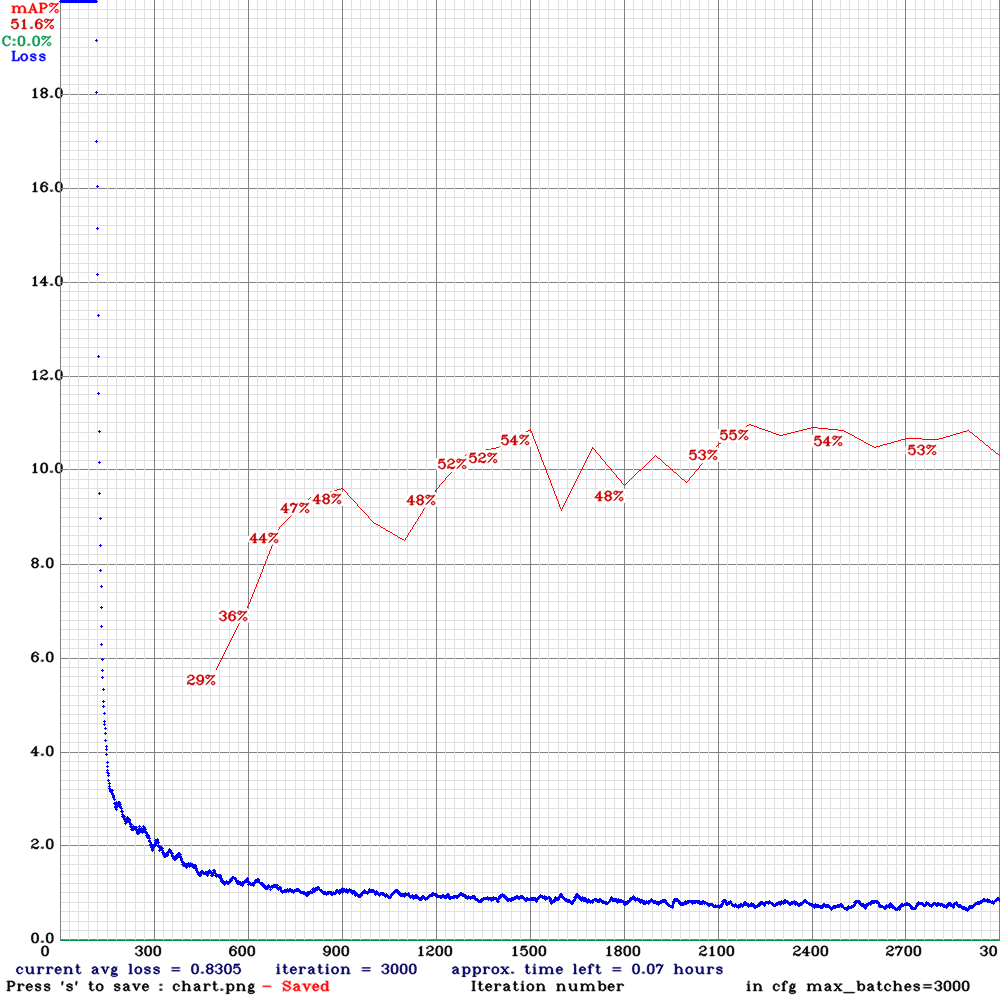

So you will see mAP-chart (red-line) in the Loss-chart Window. mAP will be calculated for each 4 Epochs using valid=valid.txt file that is specified in obj.data file (1 Epoch = images_in_train_txt / batch iterations) every 12 iteration in our case

Use the extract_log script to convert your `.log` file to the appropriate format

In [ ]:

#extract_log('/gdrive/MyDrive/Dataset_fire_detection/darknet/train.log','/gdrive/MyDrive/Dataset_fire_detection/train_log_loss.txt','images')
#extract_log('/gdrive/MyDrive/Dataset_fire_detection/darknet/train.log','/gdrive/MyDrive/Dataset_fire_detection/map.txt','mean average precision ')
#extract_log2('/gdrive/MyDrive/Dataset_fire_detection/darknet/train.log','/gdrive/MyDrive/Dataset_fire_detection/train_log_iou.txt','IoU')


Use the `train_loss_visualization.py` script to draw the loss curve

In [ ]:

#%matplotlib inline
 
lines =18798    #Change to self generated Number of rows in train_log_loss.txt

#Adjusting the following two sets of numbers will help you view the details of the drawing
start_ite = 250 #Ignore Number of all lines starting in train_log_loss.txt
end_ite = 6000 #Ignore Number of all lines ending in train_log_loss.txt
result = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 2 /train_log_loss.txt', skiprows=[x for x in range(lines) if ((x<start_ite) |(x>end_ite))] ,error_bad_lines=False, names=['loss', 'avg loss', 'rate', 'seconds', 'images'])
result.head()
df = pd.read_excel('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 2 /train_log_loss_1_.xlsx')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.style
avg =list(df['avg_loss'])
t_loss = list(df['train_loss'])
l =[]
for i,j in zip(avg,t_loss):
  l.append(2*i-j)
print(l)
df['valid_loss'] = l
df.style

In [ ]:
df.to_excel('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 2 /train_log_loss_1_2.xlsx', index = False)

#### Loss

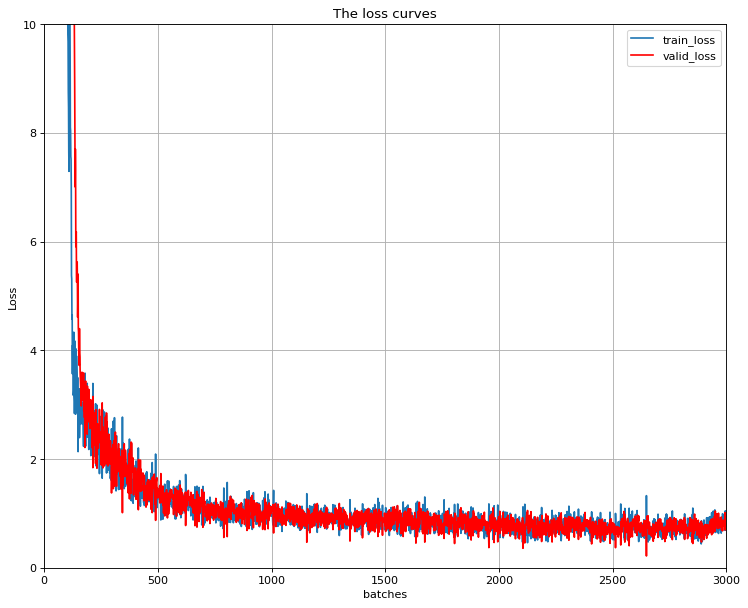

In [ ]:
df1 = pd.read_excel('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version_1/train_log_loss_1_2.xlsx')
m = list(df1['valid_loss'])
m_prime = list(df1['train_loss'])
 
fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(m_prime, label = 'train_loss')
plt.plot(m, label = 'valid_loss',color='red') # bar can be replaced by
plt.ylim(0.0,10.00) 
plt.xlim(0,3000)
ax.set_title('The loss curves')
ax.set_ylabel('Loss')
ax.set_xlabel('batches')

plt.legend(loc='best')
# scatter or line or even left as default
plt.grid()
plt.show()

#### mAP

In [ ]:
#extract_log(r'/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 2 /train.log',r'/gdrive/MyDrive/Dataset_fire_detection/map.txt','mean average precision ')

In [ ]:
with open(r"/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version_1/map.txt", "r") as txt_file:
    l = txt_file.readlines()
y = []
for i in l :
    y.append(float(i[-9:-4]))
x = [i for i in range(500, 3001, 100)]
print([(str(ay)+" %") for ay in y])

['28.78 %', '35.55 %', '43.92 %', '47.04 %', '48.06 %', '44.4 %', '42.55 %', '47.92 %', '51.72 %', '52.41 %', '54.34 %', '45.65 %', '52.43 %', '48.35 %', '51.56 %', '48.63 %', '52.69 %', '54.83 %', '53.7 %', '54.47 %', '54.25 %', '52.4 %', '53.34 %', '53.23 %', '54.19 %', '51.58 %']


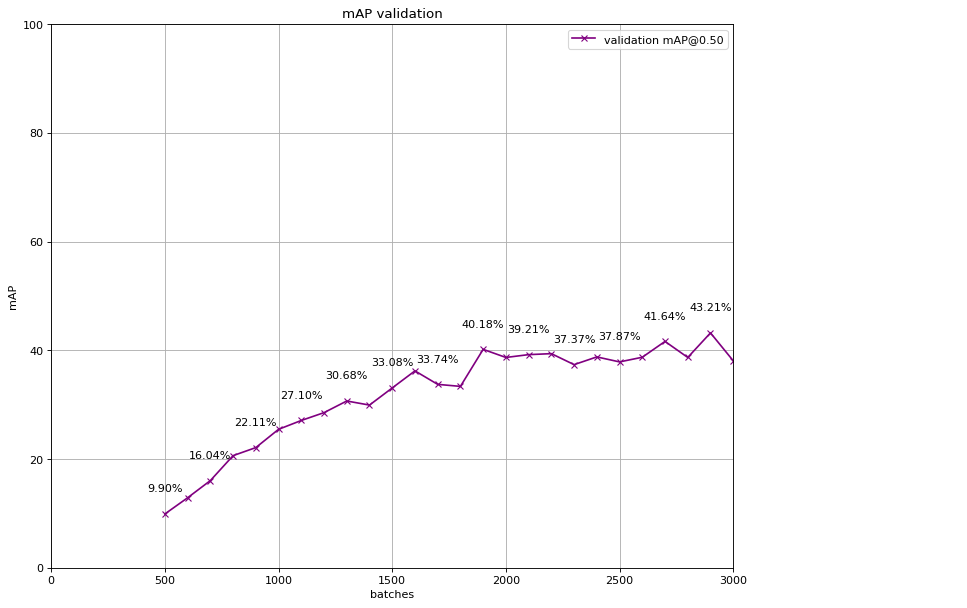

In [ ]:
fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(x,y, label = 'validation mAP@0.50',color ='purple',marker='x') # bar can be replaced by
plt.ylim(0.0,100.00) 
plt.xlim(0,3000)
ax.set_title('mAP validation')
ax.set_ylabel('mAP')
ax.set_xlabel('batches')
plt.legend(loc='best')
a = x[::2]
b = y[::2]
for i,j in zip(a,b):

    label = "{:.2f}".format(j)

    plt.annotate(label+'%', # this is the text
                 (i,j), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,20), # distance from text to points (x,y)
                 ha='center')    
plt.grid()
# scatter or line or even left as default
plt.show()

### V2
4000 baches  
learning rate 0.0001

from 0 to 2300

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file $weights_file -dont_show -map | tee train.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.711453), count: 1, class_loss = 0.128877, iou_loss = 0.073907, total_loss = 0.202784 
 total_bbox = 220760, rewritten_bbox = 0.526363 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.590520), count: 4, class_loss = 0.895006, iou_loss = 0.951449, total_loss = 1.846455 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.003213, iou_loss = 0.000000, total_loss = 0.003213 
 total_bbox = 220764, rewritten_bbox = 0.526354 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.631905), count: 5, class_loss = 0.515581, iou_loss = 0.543310, total_loss = 1.058891 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.284158, iou_loss = 0.544949, tot

In [ ]:
%ls

 3rdparty/                           core                     net_cam_v3.sh
 anchors.txt                         counters_per_class.txt   net_cam_v4.sh
 avg_loss.png                        darknet*                 obj/
 backup/                             DarknetConfig.cmake.in   predictions.jpg
 bad.list                            darknet_images.py        README.md
 build/                              darknet.py               result.json
 build.ps1                           darknet_video.py         results/
 cfg/                                data/                    result.txt
 chart.png                           image_yolov3.sh          scripts/
 chart_yolov3-tiny.png               image_yolov4.sh          src/
 cmake/                              include/                 train.log
 CMakeLists.txt                      json_mjpeg_streams.sh    vcpkg.json
'Copie de train V2.log'              LICENSE                  video_yolov3.sh
'Copie de train V3 incomplete.log'   Makefile       

2300 to 3000

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file '/gdrive/MyDrive/Dataset_fire_detection/darknet/backup/yolov3-tiny_last.weights' -dont_show -map | tee train.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.002776, iou_loss = 0.000000, total_loss = 0.002776 
 total_bbox = 59823, rewritten_bbox = 0.558314 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.594706), count: 4, class_loss = 1.002888, iou_loss = 0.477706, total_loss = 1.480593 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.001963, iou_loss = 0.000000, total_loss = 0.001963 
 total_bbox = 59827, rewritten_bbox = 0.558276 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.672151), count: 5, class_loss = 1.068644, iou_loss = 0.627350, total_loss = 1.695994 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.598667), count: 2, class_loss = 0.498967, iou_loss = 0.414831, total

from 3000 to 4000

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file '/gdrive/MyDrive/Dataset_fire_detection/darknet/backup/yolov3-tiny_last.weights' -dont_show -map | tee train.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.508559), count: 2, class_loss = 0.494642, iou_loss = 0.520370, total_loss = 1.015012 
 total_bbox = 89655, rewritten_bbox = 0.571078 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.779223), count: 5, class_loss = 1.161731, iou_loss = 0.245506, total_loss = 1.407237 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.037841), count: 1, class_loss = 0.253287, iou_loss = 0.670494, total_loss = 0.923782 
 total_bbox = 89661, rewritten_bbox = 0.571040 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.529233), count: 5, class_loss = 1.304027, iou_loss = 1.003073, total_loss = 2.307100 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.809885), count: 1, class_loss = 0.253838, iou_loss = 0.032633, total

#### Loss

In [ ]:
log_file =  '/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/trainV3 fromm 3000 to 4000.log'
dst_map ='/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/map_3.3.txt'
dst_loss ='/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/train_log_loss3.3.txt'
extract_log(log_file,dst_loss,'images')
extract_log(log_file,dst_map,'mean average precision ')

In [ ]:
with open (dst_loss, "r") as myfile:
    data = myfile.read().splitlines()
data = data[1::]
print(data)

[' 3001: 1.036632, 1.036632 avg loss, 0.000100 rate, 1.442433 seconds, 192064 images, -1.000000 hours left', ' 3002: 1.151555, 1.048125 avg loss, 0.000100 rate, 1.374956 seconds, 192128 images, 0.600207 hours left', ' 3003: 1.046806, 1.047993 avg loss, 0.000100 rate, 1.338227 seconds, 192192 images, 0.598208 hours left', ' 3004: 1.123744, 1.055568 avg loss, 0.000100 rate, 1.341689 seconds, 192256 images, 0.599472 hours left', ' 3005: 1.206827, 1.070694 avg loss, 0.000100 rate, 1.306354 seconds, 192320 images, 0.600293 hours left', ' 3006: 1.095446, 1.073169 avg loss, 0.000100 rate, 1.316353 seconds, 192384 images, 0.601240 hours left', ' 3007: 1.078851, 1.073737 avg loss, 0.000100 rate, 1.295784 seconds, 192448 images, 0.602146 hours left', ' 3008: 1.140115, 1.080375 avg loss, 0.000100 rate, 1.325038 seconds, 192512 images, 0.602685 hours left', ' 3009: 1.122424, 1.084580 avg loss, 0.000100 rate, 1.453003 seconds, 192576 images, 0.604329 hours left', ' 3010: 1.462599, 1.122382 avg loss

In [ ]:
a= [line.split(',') for line in data]
len(a)

1000

In [ ]:
loss =[]
avg_l = []
rate = []
time = []
images = []
h_left = []
df = {'loss':loss,'avg loss':avg_l,'rate':rate,'time':time,'images':images,'hours_left':h_left}
for line in a : 
  n_line = []
  for ele,key in zip(line,df.keys()):
    if line.index(ele) == 0:
      df[key].append(ele.split(':')[1])
    else:
      df[key].append(ele.split()[0])
pd.DataFrame.from_dict(df).to_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/train_log_loss3.3.csv',index = False)

In [ ]:
df_1 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/train_log_loss3.1.csv')
df_2 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/train_log_loss3.2.csv')
df_3 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/train_log_loss3.3.csv')
df_final = pd.concat([df_1, df_2,df_3])
df_final.to_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/train_valid_final_loss.csv',index= False)

In [ ]:
with open ('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/map_3.3.txt', "r") as myfile:
    map = myfile.read().splitlines()

map = [line.split()[-2] for line in map]
print(map)

['40.55', '42.14', '40.85', '39.69', '39.63', '40.06', '40.09', '42.16', '41.97', '38.26']


In [ ]:
map_f = []

In [ ]:
print(len(map_f))
z = pd.DataFrame.from_dict({'mAP':map_f})
z.style
z.to_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version 3/mAP_f.csv',index=False)

36


In [ ]:
map_f += map
print(map_f)

['9.90', '12.88', '16.04', '20.63', '22.11', '25.47', '27.10', '28.54', '30.68', '29.93', '33.08', '36.22', '33.74', '33.37', '40.18', '38.69', '39.21', '39.39', '37.37', '38.79', '37.87', '38.73', '41.64', '38.69', '43.21', '38.08', '40.55', '42.14', '40.85', '39.69', '39.63', '40.06', '40.09', '42.16', '41.97', '38.26', '40.55', '42.14', '40.85', '39.69', '39.63', '40.06', '40.09', '42.16', '41.97', '38.26']


In [ ]:
z = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version_2/train_valid_final_loss.csv')
z

loss    avg loss      rate      time  images  hours_left
0     727.994995  727.994995  0.000000  1.439106      64   -1.000000
1     728.674438  728.062927  0.000000  1.248609     128    8.815378
2     729.051270  728.161743  0.000000  1.336168     192    8.800471
3     729.539368  728.299500  0.000000  1.273244     256    8.779435
4     729.840820  728.453613  0.000000  1.240735     320    8.761621
...          ...         ...       ...       ...     ...         ...
3994    0.969805    1.105902  0.000001  1.344239  255744    0.079632
3995    1.169528    1.112265  0.000001  1.364211  255808    0.078864
3996    1.128974    1.113935  0.000001  1.378357  255872    0.078096
3997    1.586231    1.161165  0.000001  1.465753  255936    0.077332
3998    1.529408    1.197989  0.000001  1.334541  256000    0.076568

[3999 rows x 6 columns]

In [ ]:

t_l = list(z['loss'])
a_l = list(z['avg loss'])
v_l=[]
v_l = [2*float(a)-float(t) for t, a in zip(t_l,a_l)]


In [ ]:
z['valid loss']=v_l

In [ ]:
z

loss    avg loss      rate      time  images  hours_left  \
0     727.994995  727.994995  0.000000  1.439106      64   -1.000000   
1     728.674438  728.062927  0.000000  1.248609     128    8.815378   
2     729.051270  728.161743  0.000000  1.336168     192    8.800471   
3     729.539368  728.299500  0.000000  1.273244     256    8.779435   
4     729.840820  728.453613  0.000000  1.240735     320    8.761621   
...          ...         ...       ...       ...     ...         ...   
3994    0.969805    1.105902  0.000001  1.344239  255744    0.079632   
3995    1.169528    1.112265  0.000001  1.364211  255808    0.078864   
3996    1.128974    1.113935  0.000001  1.378357  255872    0.078096   
3997    1.586231    1.161165  0.000001  1.465753  255936    0.077332   
3998    1.529408    1.197989  0.000001  1.334541  256000    0.076568   

      valid loss  
0     727.994995  
1     727.451416  
2     727.272216  
3     727.059632  
4     727.066406  
...          ...  
3994    1.241999  
3995    1.055002  
3996    1.098896  
3997    0.736099  
3998    0.866570  

[3999 rows x 7 columns]

In [ ]:
z.to_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version_2/train_valid_final_loss.csv',index=False)

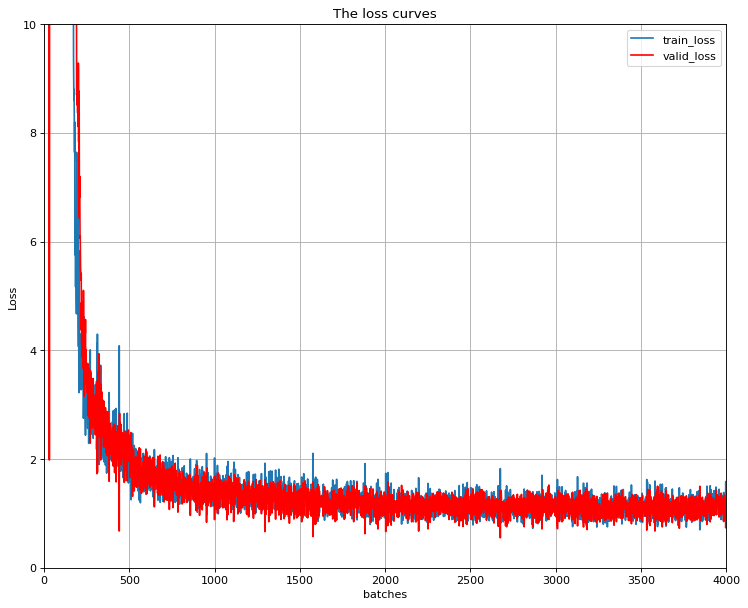

In [ ]:
df1 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version_2/train_valid_final_loss.csv')
m = list(df1['valid loss'])
m_prime = list(df1['loss'])
 
fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(m_prime, label = 'train_loss')
plt.plot(m, label = 'valid_loss',color='red') # bar can be replaced by
plt.ylim(0.0,10.00) 
plt.xlim(0,4000)
ax.set_title('The loss curves')
ax.set_ylabel('Loss')
ax.set_xlabel('batches')

plt.legend(loc='best')
# scatter or line or even left as default
plt.grid()
plt.show()

#### mAP

In [ ]:
df2 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3 tiny logs/version_2/mAP_f.csv')


In [ ]:
x = [i for i in range(500, 4001, 100)]
y = list(df2['mAP'])
print(x,y)

[500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000] [9.9, 12.88, 16.04, 20.63, 22.11, 25.47, 27.1, 28.54, 30.68, 29.93, 33.08, 36.22, 33.74, 33.37, 40.18, 38.69, 39.21, 39.39, 37.37, 38.79, 37.87, 38.73, 41.64, 38.69, 43.21, 38.08, 40.55, 42.14, 40.85, 39.69, 39.63, 40.06, 40.09, 42.16, 41.97, 38.26]


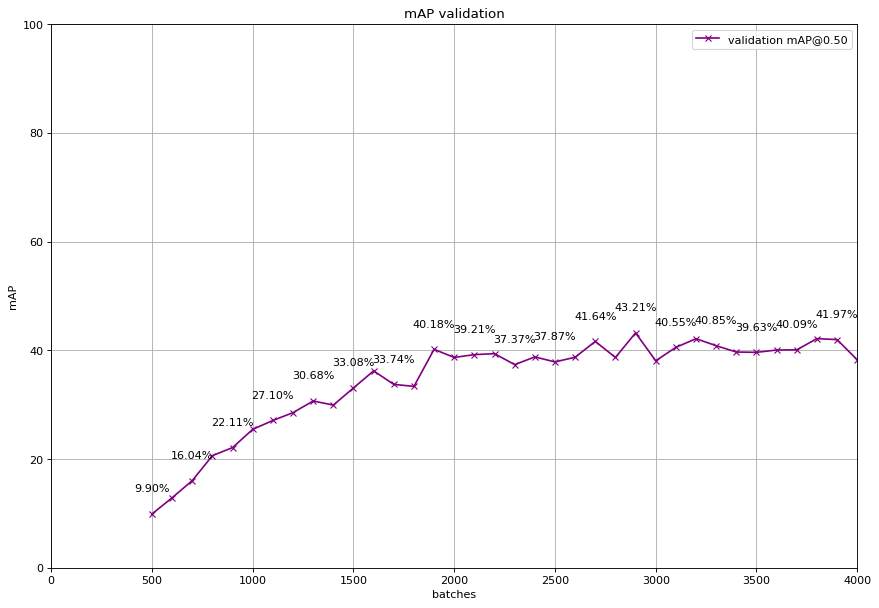

In [ ]:

fig = plt.figure(figsize=(13, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(x,y, label = 'validation mAP@0.50',color ='purple',marker="x" ) # bar can be replaced by
plt.ylim(0.0,100.00) 
plt.xlim(0,4000)
ax.set_title('mAP validation')
ax.set_ylabel('mAP')
ax.set_xlabel('batches')
plt.legend(loc='best')
a = x[::2]
b = y[::2]
for i,j in zip(a,b):

    label = "{:.2f}".format(j)

    plt.annotate(label+'%', # this is the text
                 (i,j), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,20), # distance from text to points (x,y)
                 ha='center')    
plt.grid()
# scatter or line or even left as default
plt.show()

### V3  

[net]  
batch=64  
subdivisions=16  
width=512  
height=320  
channels=3  
momentum=0.9  
decay=0.0005  
angle=0  
saturation = 1.5  
exposure = 1.5  
hue=.1  

learning_rate=0.00075  
burn_in=100  
max_batches = 2500  
policy=steps  
steps=3200,3600  
scales=.1,.1  

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file $weights_file -dont_show -map | tee trainYolov3_tiny_f.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.692865), count: 6, class_loss = 1.318191, iou_loss = 0.553217, total_loss = 1.871408 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.443135), count: 2, class_loss = 0.175175, iou_loss = 0.183755, total_loss = 0.358930 
 total_bbox = 236138, rewritten_bbox = 0.537398 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.678182), count: 7, class_loss = 1.724570, iou_loss = 0.907489, total_loss = 2.632060 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.666921), count: 1, class_loss = 0.270843, iou_loss = 0.038310, total_loss = 0.309153 
 total_bbox = 236146, rewritten_bbox = 0.537379 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.751078), count: 4, class_loss = 0.615213, iou_loss = 0.427785, tot

#### Loss

In [ ]:
p_dir = '/gdrive/MyDrive/Dataset_fire_detection/yolov3_tiny_logs/version_3'
log_file = p_dir + '/trainYolov3_tiny_f.log'
dst_map = p_dir + '/map.txt'
dst_loss = p_dir +'/train_log_loss.txt'
path_loss = p_dir + '/train_log_loss.csv'
path_map = p_dir + '/map.csv'

In [ ]:

# Extract logs
#extract_log(log_file ,dst_loss,'images')
#extract_log(log_file,dst_map,'mean average precision ')
extract_log2(p_dir + '/trainYolov3_tiny_f.log',p_dir + '/train_log_iou.txt','IoU')

In [ ]:

# reformat logs
with open (dst_loss, "r") as myfile:
    data = myfile.read().splitlines()
data = data[1::]
a = [line.split(',') for line in data]

In [ ]:
loss =[]
avg_l = []
rate = []
time = []
images = []
h_left = []
df = {'loss':loss,'avg loss':avg_l,'rate':rate,'time':time,'images':images,'hours_left':h_left}
for line in a : 
  n_line = []
  for ele,key in zip(line,df.keys()):
    if line.index(ele) == 0:
      df[key].append(ele.split(':')[1])
    else:
      df[key].append(ele.split()[0])

pd.DataFrame.from_dict(df).to_csv(path_loss,index = False)

In [ ]:
with open (dst_map, "r") as myfile:
    map = myfile.read().splitlines()

map = [line.split()[-2] for line in map]
print(map)

['5.17', '24.05', '39.11', '43.59', '49.10', '38.91', '44.41', '47.12', '44.90', '52.71', '54.63', '51.99', '48.36', '49.57', '51.98', '49.56', '53.07', '50.89', '49.70', '51.55', '53.85', '50.00', '52.06', '53.11', '47.84']


In [ ]:
z = pd.DataFrame.from_dict({'mAP':map})
z.to_csv(path_map,index=False)

In [ ]:
z = pd.read_csv(path_loss)
t_l = list(z['loss'])
a_l = list(z['avg loss'])
v_l=[]
v_l = [2*float(a)-float(t) for t, a in zip(t_l,a_l)]
z['valid loss']=v_l
z.to_csv(path_loss,index=False)

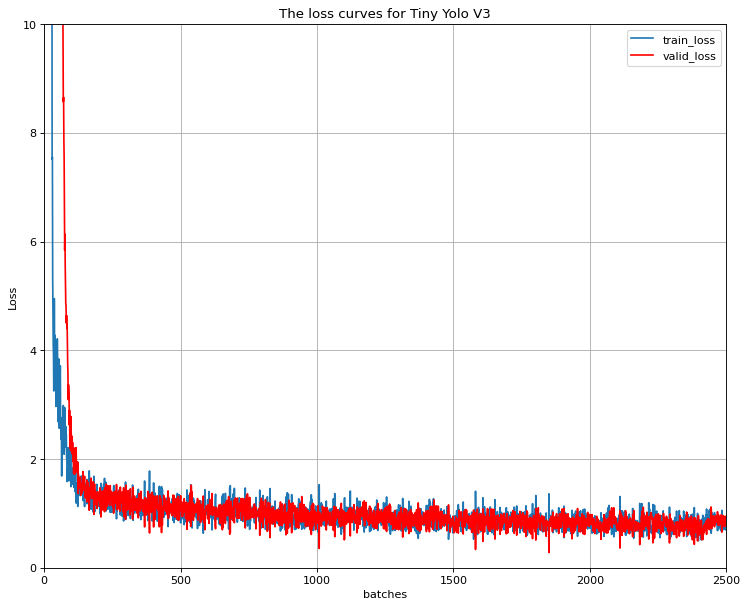

In [ ]:
#map the training loss and valid loss
df1 = pd.read_csv(path_loss)

m = list(df1['valid loss'])
m_prime = list(df1['loss'])
 
fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(m_prime, label = 'train_loss')
plt.plot(m, label = 'valid_loss',color='red') # bar can be replaced by
plt.ylim(0.0,10.00) 
plt.xlim(0,2500)
ax.set_title('The loss curves for Tiny Yolo V3')
ax.set_ylabel('Loss')
ax.set_xlabel('batches')

plt.legend(loc='best')
# scatter or line or even left as default
plt.grid()

plt.savefig('Tiny Yolov3 loss curves.png',dpi=80)
plt.show()

#### mAP

In [ ]:
df2 = pd.read_csv(path_map)
x = [i for i in range(100, 2500+1, 100)]
y = list(df2['mAP'])
print(x,y)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500] [5.17, 24.05, 39.11, 43.59, 49.1, 38.91, 44.41, 47.12, 44.9, 52.71, 54.63, 51.99, 48.36, 49.57, 51.98, 49.56, 53.07, 50.89, 49.7, 51.55, 53.85, 50.0, 52.06, 53.11, 47.84]


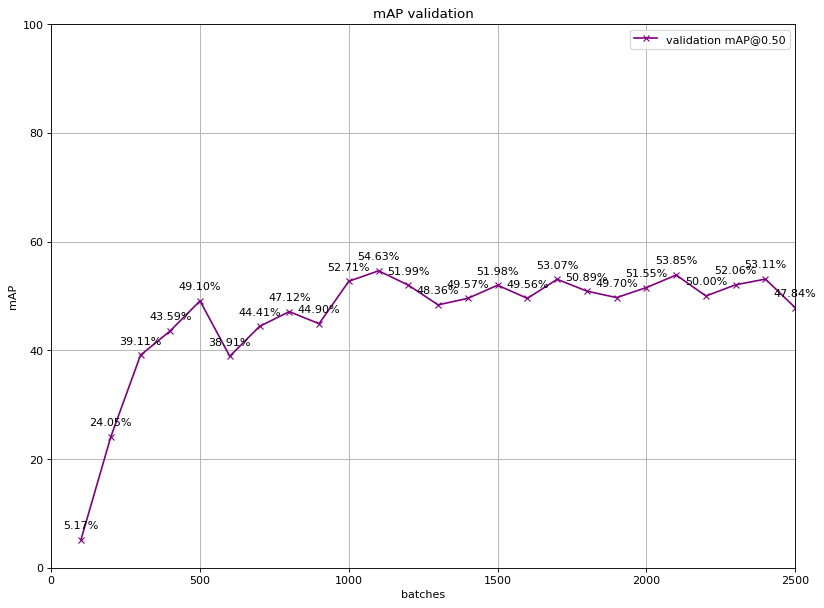

In [ ]:

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(x,y, label = 'validation mAP@0.50',color ='purple',marker='x') # bar can be replaced by
plt.ylim(0.0,100.00) 
plt.xlim(0,2500)
ax.set_title('mAP validation')
ax.set_ylabel('mAP')
ax.set_xlabel('batches')
plt.legend(loc='best')

for i,j in zip(x,y):

    label = "{:.2f}".format(j)

    plt.annotate(label+'%', # this is the text
                 (i,j), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.grid()
# scatter or line or even left as default
plt.savefig('Tiny Yolov3 mAP validation.png',dpi=80)
plt.show()


## Testing and evaluation

### v3

In [ ]:
with open('/gdrive/MyDrive/Dataset_fire_detection/data/test.txt', 'r') as f:
    myTest = [line.strip() for line in f]

In [ ]:
print(myTest)

['/gdrive/MyDrive/Dataset_fire_detection/data/Test/003_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/004_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/006_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/007_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/011_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/012_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/015_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/016_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/021_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/030_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/040_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/042_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/057_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/067_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/069_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection

In [ ]:
weights_best = '/gdrive/MyDrive/Dataset_fire_detection/yolov3_tiny_logs/version_3/yolov3_tiny_best.weights'

In [ ]:
!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best '/gdrive/MyDrive/Dataset_fire_detection/data/Test/004_rgb.png' -ext_output

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128

In [ ]:
for c in range(len(myTest)):
  test_im = myTest[c]
  new_name = myTest[c].split('/')[-1]
  test_im ='\(\\'.join(test_im.split('('))
  test_im ='\)\\'.join(test_im.split(')'))
  !./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best $test_im -ext_output

  print('Done predicting !')

  test_im = ''.join(test_im.split('\\'))
  src = '/gdrive/MyDrive/Dataset_fire_detection/darknet/predictions.jpg'
  file_name = '/gdrive/MyDrive/Dataset_fire_detection/darknet'

  new_name = test_im.split('/')[-1]
  new_src = os.path.join(file_name,new_name)

  file_dst = '/gdrive/MyDrive/Dataset_fire_detection/data/yolov3_tiny_v3_results'
  dst = os.path.join(file_dst,new_name)
  print('')

  os.rename(src, new_src)
  print(f'renaming {src} ========> {new_src}')
  print('__________________')
  shutil.move(new_src, dst)
  print(f'moving from {new_src} =========> {dst}\n')
  print('__________________')
  print('__________________')



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0

In [ ]:
%ls

3rdparty/               DarknetConfig.cmake.in  net_cam_v4.sh
backup/                 darknet_images.py       obj/
bad.list                darknet.py              predictions.jpg
build/                  darknet_video.py        README.md
build.ps1               data/                   result.json
cfg/                    image_yolov3.sh         results/
chart.png               image_yolov4.sh         result.txt
chart_yolov3-tiny.png   include/                scripts/
cmake/                  json_mjpeg_streams.sh   src/
CMakeLists.txt          LICENSE                 vcpkg.json
counters_per_class.txt  Makefile                video_yolov3.sh
darknet*                net_cam_v3.sh           video_yolov4.sh


In [ ]:
!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best '/gdrive/MyDrive/Dataset_fire_detection/data/Test/153_rgb.png' -ext_output


 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128

In [ ]:
img = cv2.imread("predictions.jpg")
cv2_imshow(img)

In [ ]:
#!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best /gdrive/MyDrive/Dataset_fire_detection/data/Test/004_rgb.png -ext_output


 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128

In [ ]:
img = cv2.imread("predictions.jpg")
cv2_imshow(img)

In [ ]:
!./darknet detector map /gdrive/MyDrive/Dataset_fire_detection/obj_test.data $cfg_file $weights_best -points 0

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128

In [ ]:
%ls

3rdparty/               DarknetConfig.cmake.in  net_cam_v4.sh
backup/                 darknet_images.py       obj/
bad.list                darknet.py              predictions.jpg
build/                  darknet_video.py        README.md
build.ps1               data/                   results/
cfg/                    image_yolov3.sh         result.txt
chart.png               image_yolov4.sh         scripts/
chart_yolov3-tiny.png   include/                src/
cmake/                  json_mjpeg_streams.sh   vcpkg.json
CMakeLists.txt          LICENSE                 video_yolov3.sh
counters_per_class.txt  Makefile                video_yolov4.sh
darknet                 net_cam_v3.sh


In [ ]:
#with open('/gdrive/MyDrive/Dataset_fire_detection/data/test.txt', 'r') as f:
#    myTest = [line.strip() for line in f]
#myTest[0].split('/')[-1]

In [ ]:
"""c = 0

import subprocess

for test_im in myTest :
  c += 1
  src = '/gdrive/MyDrive/Dataset_fire_detection/darknet/predictions.jpg'
  file_name = '/gdrive/MyDrive/Dataset_fire_detection/darknet'
  new_name = test_im.split('/')[-1]
  new_src = os.path.join(file_name,new_name)
  file_dst = '/gdrive/MyDrive/Dataset_fire_detection/data/yolov3_tiny_v1_results'
  dst = os.path.join(file_dst,new_name)
  cmd_stuff = test_im +' -ext_output'
  cmd_first_part = './darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best '
  cmd = cmd_first_part + cmd_stuff
  print(cmd)
  
  print('\n')
  

  #os.rename(src, new_src)
  print(f'renaming {src} ========> {new_src}')

  #shutil.move(new_src, dst)
  print(f'moving from {new_src} =========> {dst}')
  
  print('done lmao !')
  if c == 5 :
    break"""

In [ ]:
import subprocess
subprocess.run("!cd ..",shell =True)

CompletedProcess(args='!cd ..', returncode=127)

In [ ]:
%ls

3rdparty/               DarknetConfig.cmake.in  net_cam_v4.sh
backup/                 darknet_images.py       obj/
bad.list                darknet.py              predictions.jpg
build/                  darknet_video.py        README.md
build.ps1               data/                   result.json
cfg/                    image_yolov3.sh         results/
chart.png               image_yolov4.sh         result.txt
chart_yolov3-tiny.png   include/                scripts/
cmake/                  json_mjpeg_streams.sh   src/
CMakeLists.txt          LICENSE                 vcpkg.json
counters_per_class.txt  Makefile                video_yolov3.sh
darknet*                net_cam_v3.sh           video_yolov4.sh


### RESULT.TXT

In [ ]:
!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best -dont_show -ext_output < /gdrive/MyDrive/Dataset_fire_detection/data/test.txt > result.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     32 x  20 x 128 ->   32 x  20 x 256 0.377 BF
   9 max                2x 2/ 2     32 x  20 x 256 -> 

### RESULT.JSON

In [ ]:
!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best -ext_output -dont_show -out result.json < /gdrive/MyDrive/Dataset_fire_detection/data/test.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128